In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

from gensim.models import Word2Vec
from konlpy.tag import Okt

from tensorflow.keras.models import Sequential
from tensorflow.keras import regularizers
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, BatchNormalization, Bidirectional

from sklearn.metrics import f1_score, classification_report, confusion_matrix, accuracy_score

import pickle
from tensorflow.keras.optimizers import Adam

C:\Anaconda3\lib\site-packages\paramiko\pkey.py:82: CryptographyDeprecationWarning: TripleDES has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.TripleDES and will be removed from this module in 48.0.0.
  "cipher": algorithms.TripleDES,
C:\Anaconda3\lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.Blowfish and will be removed from this module in 45.0.0.
  "class": algorithms.Blowfish,
C:\Anaconda3\lib\site-packages\paramiko\transport.py:243: CryptographyDeprecationWarning: TripleDES has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.TripleDES and will be removed from this module in 48.0.0.
  "class": algorithms.TripleDES,


#### 이미 전처리해서 중복 등을 제거한 좋은 데이터로 시작
각 클래스는 정수인코딩 되어있고   
협박 대화 = 0,  
갈취 대화 = 1,  
직장 내 괴롭힘 대화 = 2,  
기타 괴롭힘 대화 = 3,  
일반 = 4   

In [2]:
# train 데이터 로드
# train_data = pd.read_csv("C:/Users/양자/Desktop/Hun_Works/AIFFEL_DLthon/DLThon01/CHYeom/data/train.csv")
# 증강된 데이터 쓰기
train_data = pd.read_csv("C:/Users/양자/Desktop/Hun_Works/AIFFEL_DLthon/DLThon01/CHYeom/data/augmented_train.csv")
print('훈련용 텍스트 개수 :',len(train_data))
print(train_data['class'].unique())

훈련용 텍스트 개수 : 14364
[0 3 1 2 4]


In [3]:
# 텍스트 길이 계산
train_data['text_length'] = train_data['conversation'].astype(str).apply(len)

# 길이 통계 출력
print("훈련용 텍스트 개수:", len(train_data))
print("클래스 종류:", train_data['class'].unique())

print("텍스트 길이 통계:")
print("최소 길이:", train_data['text_length'].min())
print("최대 길이:", train_data['text_length'].max())
print("평균 길이:", train_data['text_length'].mean())
print("중앙값:", train_data['text_length'].median())
print("표준 편차:", train_data['text_length'].std())

# 길이 분포 히스토그램 시각화
import matplotlib.pyplot as plt

훈련용 텍스트 개수: 14364
클래스 종류: [0 3 1 2 4]
텍스트 길이 통계:
최소 길이: 34
최대 길이: 912
평균 길이: 203.71553884711778
중앙값: 181.0
표준 편차: 103.78763608113039


In [4]:
okt=Okt()

tokenized_data = [okt.morphs(sentence) for sentence in train_data['conversation']]

embedding_model = Word2Vec(sentences=tokenized_data,
							sg = 1,
                            vector_size = 128,
                            window = 10,
                            min_count = 1,
                            workers = 4)

In [7]:
tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(tokenized_data)
train_X = tokenizer.texts_to_sequences(tokenized_data)

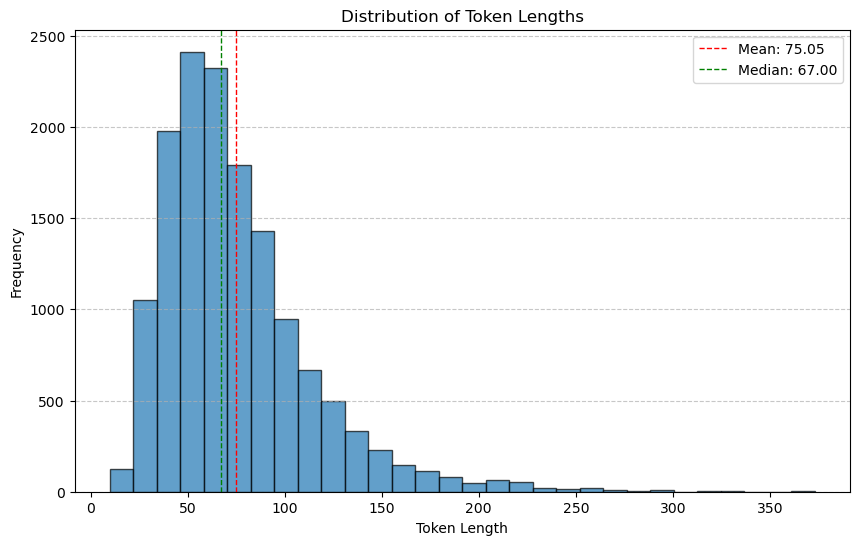

In [9]:
# Compute token lengths
token_lengths = [len(seq) for seq in train_X]

# Compute statistics
mean_length = np.mean(token_lengths)
std_length = np.std(token_lengths)
min_length = np.min(token_lengths)
max_length = np.max(token_lengths)
median_length = np.median(token_lengths)

# Create a DataFrame for statistics
stats_df = pd.DataFrame({
    "Statistic": ["Mean", "Standard Deviation", "Min", "Max", "Median"],
    "Value": [mean_length, std_length, min_length, max_length, median_length]
})

# Plot histogram of token lengths
plt.figure(figsize=(10, 6))
plt.hist(token_lengths, bins=30, edgecolor='black', alpha=0.7)
plt.axvline(mean_length, color='r', linestyle='dashed', linewidth=1, label=f'Mean: {mean_length:.2f}')
plt.axvline(median_length, color='g', linestyle='dashed', linewidth=1, label=f'Median: {median_length:.2f}')
plt.xlabel("Token Length")
plt.ylabel("Frequency")
plt.title("Distribution of Token Lengths")
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


In [11]:
vocab_size=10000
max_len = 150 # 평균 + 1.5 * 표준편차 한 것 

train_X = tokenizer.texts_to_sequences(tokenized_data)
train_X = pad_sequences(train_X, maxlen=max_len, padding='pre')
train_y = train_data['class'].values

In [12]:
train_X, val_X, train_y, val_y = train_test_split(train_X, train_y, test_size=0.2, random_state=42)

In [13]:
print(f"training data size: {len(train_X)}")
print(f"validation data size: {len(val_X)}")

training data size: 11491
validation data size: 2873


# LSTM 모델 구성하기

In [33]:
def BiLSTM(embedding_dim, lstm_units, num_layers):
    
    model = Sequential()

    model.add(Embedding(vocab_size, embedding_dim, input_length=max_len))

    for i in range(num_layers):
        model.add(Bidirectional(LSTM(int(lstm_units / (2 ** i)) , return_sequences=(i < num_layers - 1))))
        model.add(Dropout(0.3))

    model.add(Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))
    
    model.add(Dense(5, activation='softmax'))

    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model


In [34]:
# 모델 3개 생성
BiLSTM1 = BiLSTM(embedding_dim=256, lstm_units=256, num_layers=4)
BiLSTM2 = BiLSTM(embedding_dim=128, lstm_units=128, num_layers=3)
BiLSTM3 = BiLSTM(embedding_dim=64, lstm_units=64, num_layers=2)

# callbacks
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)
es = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

# 모델 학습
history1 = BiLSTM1.fit(train_X, train_y,
                        batch_size = 64,
                        epochs = 10,
                        validation_data = (val_X, val_y),
                        callbacks=[es, lr]
                       )

history2 = BiLSTM2.fit(train_X, train_y,
                        batch_size = 32,
                        epochs = 10,
                        validation_data = (val_X, val_y),
                        callbacks=[es, lr]
                       )

history3 = BiLSTM3.fit(train_X, train_y,
                        batch_size = 32,
                        epochs = 10,
                        validation_data = (val_X, val_y),
                        callbacks=[es, lr]
                       )


Epoch 1/10
180/180 [==============================] - 105s 531ms/step - loss: 1.1838 - accuracy: 0.7287 - val_loss: 0.9465 - val_accuracy: 0.8594 - lr: 0.0010
Epoch 2/10
180/180 [==============================] - 97s 539ms/step - loss: 0.3735 - accuracy: 0.9588 - val_loss: 0.3722 - val_accuracy: 0.9248 - lr: 0.0010
Epoch 3/10
180/180 [==============================] - 101s 561ms/step - loss: 0.1712 - accuracy: 0.9817 - val_loss: 0.2033 - val_accuracy: 0.9561 - lr: 0.0010
Epoch 4/10
180/180 [==============================] - 98s 547ms/step - loss: 0.0857 - accuracy: 0.9903 - val_loss: 0.1355 - val_accuracy: 0.9687 - lr: 0.0010
Epoch 5/10
180/180 [==============================] - 95s 530ms/step - loss: 0.0607 - accuracy: 0.9903 - val_loss: 0.2301 - val_accuracy: 0.9454 - lr: 0.0010
Epoch 6/10
180/180 [==============================] - 97s 537ms/step - loss: 0.0466 - accuracy: 0.9906 - val_loss: 0.1406 - val_accuracy: 0.9690 - lr: 0.0010
Epoch 1/10
360/360 [==============================

In [35]:
pred_train1 = BiLSTM1.predict(train_X)
pred_train2 = BiLSTM2.predict(train_X)
pred_train3 = BiLSTM3.predict(train_X)
meta_train = np.concatenate([pred_train1, pred_train2, pred_train3], axis=1)

pred_val1 = BiLSTM1.predict(val_X)
pred_val2 = BiLSTM2.predict(val_X)
pred_val3 = BiLSTM3.predict(val_X)
meta_val = np.concatenate([pred_val1, pred_val2, pred_val3], axis=1)

90/90 [==============================] - 5s 50ms/step


In [36]:
print(meta_train[:1])
print(meta_train.shape[1])
print(train_y[:1])

[[3.1549684e-04 9.9913764e-01 2.3001355e-04 2.7988630e-04 3.6869576e-05
  6.2296691e-05 9.9988472e-01 5.6371177e-06 3.4540888e-05 1.2779495e-05
  7.5900111e-06 9.9998546e-01 1.9341010e-06 3.2779531e-06 1.6186551e-06]]
15
[1]


In [39]:
# 메타 모델
meta_model = Sequential()

meta_model.add(Dense(128, activation='gelu', input_shape=(15,), kernel_regularizer=regularizers.l2(0.01)))
meta_model.add(BatchNormalization())
meta_model.add(Dropout(0.4))
meta_model.add(Dense(64, activation='gelu', kernel_regularizer=regularizers.l2(0.01)))
meta_model.add(BatchNormalization())
meta_model.add(Dropout(0.4))
meta_model.add(Dense(32, activation='gelu', kernel_regularizer=regularizers.l2(0.01)))
meta_model.add(BatchNormalization())
meta_model.add(Dropout(0.4))
meta_model.add(Dense(5, activation='softmax'))

meta_model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(learning_rate=0.005), metrics=['accuracy'])

# Stacking 학습
meta_model.fit(meta_train, train_y,
               validation_data=(meta_val, val_y),
               epochs=15,
               batch_size=64,
              )


Epoch 1/15
180/180 [==============================] - 3s 9ms/step - loss: 0.5543 - accuracy: 0.9867 - val_loss: 1.5498 - val_accuracy: 0.3690
Epoch 2/15
180/180 [==============================] - 1s 8ms/step - loss: 0.0574 - accuracy: 0.9985 - val_loss: 0.2159 - val_accuracy: 0.9791
Epoch 3/15
180/180 [==============================] - 1s 8ms/step - loss: 0.0674 - accuracy: 0.9983 - val_loss: 0.1554 - val_accuracy: 0.9843
Epoch 4/15
180/180 [==============================] - 1s 7ms/step - loss: 0.0940 - accuracy: 0.9976 - val_loss: 0.2091 - val_accuracy: 0.9805
Epoch 5/15
180/180 [==============================] - 1s 8ms/step - loss: 0.1058 - accuracy: 0.9976 - val_loss: 0.3593 - val_accuracy: 0.9826
Epoch 6/15
180/180 [==============================] - 1s 8ms/step - loss: 0.1134 - accuracy: 0.9973 - val_loss: 0.6506 - val_accuracy: 0.9725
Epoch 7/15
180/180 [==============================] - 1s 8ms/step - loss: 0.1261 - accuracy: 0.9970 - val_loss: 0.2944 - val_accuracy: 0.9868
Epoch 

In [40]:
test_df = pd.read_csv("C:/Users/양자/Desktop/Hun_Works/AIFFEL_DLthon/DLThon01/CHYeom/data/test.csv")

In [42]:
test_texts = test_df['text'].tolist()  # 테스트 데이터의 텍스트 추출
tokenized_test = [okt.morphs(sentence) for sentence in test_texts]  # 형태소 분석 적용
test_X = tokenizer.texts_to_sequences(tokenized_test)  # 기존에 학습된 Tokenizer를 사용해 정수 인덱스로 변환
test_X = pad_sequences(test_X, maxlen=max_len, padding='pre')

print("Test 데이터 Shape:", len(test_X))  # (샘플 수, max_len)

Test 데이터 Shape: 500


In [43]:
pred_test1 = BiLSTM1.predict(test_X)
pred_test2 = BiLSTM2.predict(test_X)
pred_test3 = BiLSTM3.predict(test_X)

meta_test = np.concatenate([pred_test1, pred_test2, pred_test3], axis=1)

16/16 [==============================] - 1s 48ms/step


In [44]:
test_pred = meta_model.predict(meta_test)

16/16 [==============================] - 0s 3ms/step


In [45]:
test_pred_labels = np.argmax(test_pred,axis=1)

In [46]:
# 인덱스 열 생성 (t_000 ~ t_499)
idx_column = [f"t_{i:03d}" for i in range(len(test_pred_labels))]

# DataFrame 생성
submission_df = pd.DataFrame({
    "idx": idx_column,
    "target": test_pred_labels
})

# 확인
print(submission_df.head(10))  # 상위 10개 출력

# CSV로 저장
submission_df.to_csv("submission_BiLSTM.csv", index=False)

print("CSV 저장 완료: submission_BiLSTM.csv")


     idx  target
0  t_000       1
1  t_001       2
2  t_002       0
3  t_003       2
4  t_004       3
5  t_005       0
6  t_006       0
7  t_007       1
8  t_008       3
9  t_009       1
CSV 저장 완료: submission_BiLSTM.csv
